# Week 8 - Multivariate Analysis

## Please run the cells of the notebook as you get to them while reading

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import decomposition
from sklearn import linear_model
from sklearn import metrics

# 1. Lesson: Multivariate graphs

In this lesson, we'll consider some multivariate plots: heatmaps and bubble plots.  We'll also consider principal component analysis and multiple regression.

### Heatmaps

In this plot, we use a heatmap to count the total traffic tickets given to citizens.  A heatmap requires the x and y axes to be categorical, while the color involves a third, numerical variable.  In this example, each row of the DataFrame represents a traffic ticket given to one person in a particular city and year.  The data are given as three columns (city, year, and ticket), so we must use a pivot_table to transform it into a two-dimensional grid.  The cmap is set to "Blues" in the first example, meaning that the heatmap uses only blue as its color.  However, we could also use a multicolor map like "viridis" in the second example.  I personally think "Blues" is easier to read - what do you think?  Here is a reference guide to the color maps:

https://matplotlib.org/stable/gallery/color/colormap_reference.html

In [2]:
np.random.seed(0)
num_samples = 100
city_series = np.random.choice(["New York", "Boston", "Atlanta", "Washington, D. C."], size = num_samples)
year_series = np.random.choice([2018, 2019, 2020], size = num_samples)
ticket_series = np.random.randint(50, 150, size = num_samples) # Traffic tickets can be from $50 to $150
df = pd.DataFrame({"city": city_series, "year": year_series, "ticket": ticket_series})
pivot = df.pivot_table(index = ["city"], columns = ["year"], values = "ticket", aggfunc = "sum")

In [3]:
df.iloc[0:5] # first five rows of a long DataFrame

,city,year,ticket
0,New York,2019,79
1,"Washington, D. C.",2020,71
2,Boston,2018,75
3,New York,2018,130
4,"Washington, D. C.",2020,110


In [4]:
pivot # 2 by 2 grid showing total ticket amounts

year,2018,2019,2020
city,,,
Atlanta,742,440,538
Boston,775,628,922
New York,1122,841,596
"Washington, D. C.",1258,451,1385


Text(0.5, 1.0, 'Total traffic tickets by city and year')

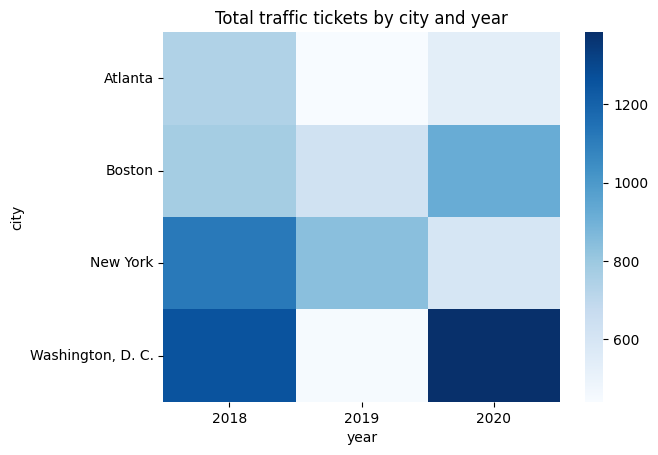

In [5]:
ax = sns.heatmap(pivot, cmap = "Blues")
ax.set_title("Total traffic tickets by city and year")

Text(0.5, 1.0, 'Average traffic ticket value by city and year')

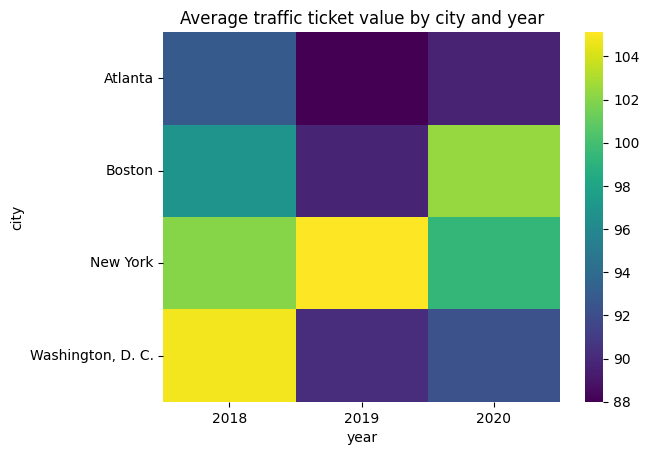

In [6]:
pivot2 = df.pivot_table(index = ["city"], columns = ["year"], values = "ticket", aggfunc = "mean") # note mean, not sum this time
ax2 = sns.heatmap(pivot2, cmap = "viridis") # do you think this is a better or worse scale than Blues?
ax2.set_title("Average traffic ticket value by city and year")

### Bubble plots

A bubble plot is just a scatter plot, but with the dot size representing a third variable.  Here, each data point shows a tree (I mean the kind of tree that is a plant and grows in the ground, not a decision tree), with its height, width of branches, and root depth.  The bubble size in the bubble plot represents the root depth, while the other variables are shown on the x and y axes.  From this plot, we can see that the root depth is strongly correlated with both the width of branches and the tree height.

Text(0, 0.5, 'width of branches')

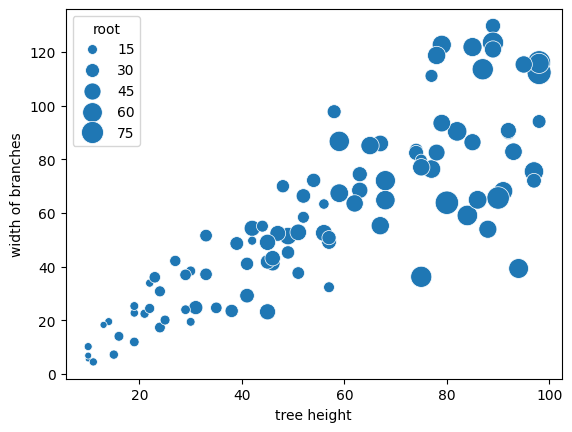

In [7]:
np.random.seed(0)
num_samples = 100
height_series = np.random.randint(10, 100, size = num_samples) # tree height
width_series = height_series * np.maximum(np.random.normal(scale = 0.3, loc = 1, size = num_samples), 0.25) # strongly related to height
root_series = height_series * np.maximum(np.random.normal(scale = 0.2, loc = 0.7, size = num_samples), 0.3) # strongly related to height
df2 = pd.DataFrame({'height': height_series, 'width': width_series, 'root': root_series})
minroot = root_series.min()
maxroot = root_series.max()
maxbubble = 300
ax = sns.scatterplot(data = df2, x = "height", y = "width", size = "root", sizes = (minroot / maxroot * maxbubble, maxbubble))
ax.set_xlabel("tree height")
ax.set_ylabel("width of branches")

### Principal Component Analysis

Principal Component Analysis can be thought of as a way to use one (or a few) linear combinations of the coordinates in order to explain all of the coordinates.  It is most useful when there are strong correlations between some or all of the coordinates.  Principal Component Analysis can show us which linear combinations are most (and least) useful for explaining the data.

With the trees data, the three values (height, width, and root) are highly correlated.  For this reason, Principal Component Analysis shows that most of the variance can be explained by a single value which is a linear combination of height, width, and root.  What this means is that if the first components_ vector in the code below (the "first principal component") is \[a, b, c\], for some specific numbers a, b, and c, then the value v = a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r), where the mu's are the means, is highly informative about the values of height, width, and root.  In this case, because height, width, and root are so highly correlated, we can almost assume that all of the data is located along an axis defined by the vector \[a, b, c\].  The point v * \[a, b, c\] + (mean vector) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (mean vector) is therefore approximately equal to the data point (height, width, root) in question.  The mean vector is \[mu_h, mu_w, mu_r\].  Importantly, there is still variance unexplained by this one value - just knowing v * \[a, b, c\] does not tell you the height, width, and root with 100% accuracy.  If the second principal component is \[d, e, f\], then we could approximate the tree vector even more accurately as: (height, width, root) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (d * (height - mu_h) + e * (width - mu_w) + f * (root - mu_r)) * \[d, e, f\] + (mean vector).

The printing of "components_", below, shows the first principal component \[a, b, c\].  If you draw a vector in the direction shown, you will be heading in the direction where the values height, width, and root change most rapidly.  A later computation shows all three principal component vectors.

**Optional exercise for the reader:** show that if all three principal components are included, then equality is exact.  This is going to be true simply because the principal components are orthonormal: the projections onto a complete set of orthonormal vectors always add up to the original vector.

(height, width, root) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (d * (height - mu_h) + e * (width - mu_w) + f * (root - mu_r)) * \[d, e, f\] + (g * (height - mu_h) + h * (width - mu_w) + i * (root - mu_r)) * \[g, h, i\] + \[mu_h, mu_w, mu_r\].

For this proof, we must use the fact that the principal component vectors are orthonormal.  That is, any pair of them are orthogonal, even with a transpose (ad + be + cf = 0, ag + bh + ci = 0, dg + eh + fi = 0, ab + de + gh = 0, ac + df + gi = 0, bc + ef + hi = 0) and any one of them is a unit vector, even with a transpose (a^2 + b^c + c^2 = 1, d^2 + e^2 + f^2 = 1, g^2 + h^2 + i^2 = 1, a^2 + d^2 + g^2 = 1, b^2 + e^2 + h^2 = 1, c^2 + f^2 + i^2 = 1).  If you write out the equation above as a single vector, then apply the orthonormality rules, you should be able to prove equality.

In [8]:
pca = decomposition.PCA(n_components = 1)
pca.fit(df2)
print(f"The first principal component explains {pca.explained_variance_ratio_[0]} of the variance")
print(f"The components_ vector is [a, b, c] = {pca.components_}")
mu_h, mu_w, mu_r = df2.mean().values
print(f"(height, width, root) is approximately equal to ({pca.components_[0][0]:.2} * (height - {mu_h:.2}) + {pca.components_[0][1]:.2} * (width - {mu_w:.2}) + {pca.components_[0][2]:.2} * (root - {mu_r:.2})) * ({pca.components_[0][0]:.2}, {pca.components_[0][1]:.2}, {pca.components_[0][2]:.2}) + ({mu_h:.2}, {mu_w:.2}, {mu_r:.2})")
print("Examples: (estimating the the vector equals its projection onto the first principal component)")
df_example = df2.copy()
df_example["v"] = pca.components_[0][0] * (df2["height"] - mu_h) + pca.components_[0][1] * (df2["width"] - mu_w) + pca.components_[0][2] * (df2["root"] - mu_r)
df_example["height_est"] = df_example["v"] * pca.components_[0][0] + mu_h
df_example["width_est"] = df_example["v"] * pca.components_[0][1] + mu_w
df_example["root_est"] = df_example["v"] * pca.components_[0][2] + mu_r
print(df_example.iloc[0:5])
print("Means:")
print(f"mu_h = {mu_h:.3}", f"mu_w = {mu_w:.3}", f"mu_r = {mu_r:.3}")

The first principal component explains 0.8686108480944689 of the variance
The components_ vector is [a, b, c] = [[0.59031629 0.71908728 0.36666083]]
(height, width, root) is approximately equal to (0.59 * (height - 5.6e+01) + 0.72 * (width - 5.9e+01) + 0.37 * (root - 3.6e+01)) * (0.59, 0.72, 0.37) + (5.6e+01, 5.9e+01, 3.6e+01)
Examples: (estimating the the vector equals its projection onto the first principal component)
   height       width       root          v  height_est  width_est   root_est
0      54   72.139334  31.517932   6.287751   60.001762  63.563941  38.673095
1      57   49.169527  33.768693  -7.633330   51.783921  53.553468  33.568780
2      74   83.443733  28.770850  25.215680   71.175227  77.174773  45.613225
3      77   76.353866  53.061241  30.794730   74.468631  81.186597  47.658844
4      77  111.095365  26.006307  45.856916   83.360084  92.017624  53.181557
Means:
mu_h = 56.3 mu_w = 59.0 mu_r = 36.4


If we were to choose a second or third component to preserve, that values below show that each would explain a small, additional amount of the variance.  This means that with this particular dataset, we should likely do PCA using only one component and not two.  If the components' explained variances were closer in magnitude to each other, we might have to include two or even all three values to explain the data.

In [9]:
pca3 = decomposition.PCA(n_components = 3)
pca3.fit(df2)
print(pca3.explained_variance_ratio_)
print(pca3.components_)

[0.86861085 0.09414617 0.03724298]
[[ 0.59031629  0.71908728  0.36666083]
 [ 0.32633701 -0.62809127  0.70640322]
 [ 0.73826204 -0.29734633 -0.6054373 ]]


The principal component vectors shown are orthogonal to each other (their dot product is basically zero).  Here, we check that using the first two vectors.

In [10]:
print(np.array(pca3.components_[0]).dot(np.array(pca3.components_[1])))

-1.6653345369377348e-16


We can use the projection onto the first principal component as if it were a new feature.  For instance, we could plot a histogram of the data against the magnitude of the projection onto the first principal component.  In fact, for some purposes, this magnitude (which we have called v) might make a better feature for data analysis than either height, width, or root.  We must subtract off the mean before the dot product; the understanding is that this represents the component of the data relative to the mean.

<Axes: >

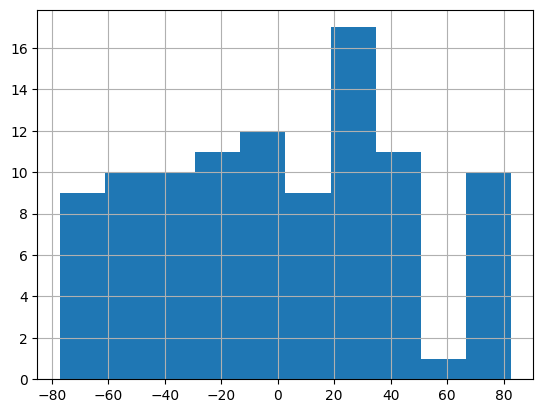

In [11]:
((df2 - df2.mean()).dot(np.array(pca.components_[0]))).hist()

In [12]:
# Showing that this is the same as the value we've called "v"
(df_example["v"] - (df2 - df2.mean()).dot(np.array(pca.components_[0]))).max()

np.float64(0.0)

### Linear Regression

Now let's run a linear regression model to predict the root from the height and width, as well as predicting the third principal component from the first and second.  Which is easier to predict?

### Predicting the root from the height and width

In [13]:
linreg = linear_model.LinearRegression()
linreg.fit(df2[['height', 'width']], df2['root'])
preds = linreg.predict(df2[['height', 'width']])
metrics.mean_squared_error(preds, df2['root']) # Mean squared error as a metric

138.22487356329611

In [14]:
np.corrcoef(preds, df2['root']) # Correlation coefficient as a metric

array([[1.        , 0.79468295],
       [0.79468295, 1.        ]])

### Predicting the third principal component from the first and second

In [15]:
first_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[0]))
second_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[1]))
third_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[2]))

In [16]:
linreg_first = linear_model.LinearRegression()
pc_X = np.array([first_principal_component_score, second_principal_component_score]).T
linreg_first.fit(pc_X, third_principal_component_score)
preds = linreg_first.predict(pc_X)
metrics.mean_squared_error(preds, third_principal_component_score) # The mean squared error is a bit smaller here.

78.74928905273173

In [17]:
np.corrcoef(preds, third_principal_component_score) # More importantly, the correlation is basically zero

array([[1.00000000e+00, 1.55375616e-14],
       [1.55375616e-14, 1.00000000e+00]])

Here, we see that the projections of the first two principal components have no ability to predict the projection of the third, when measured by correlation.  This is a special property of principal components.  It is intended to ensure that the each component gives new information not present in the previous components.

The mean_squared_error is misleading - it makes it look like the error is less for the second computation than the first; but the correlation coefficient is giving more useful information here.  We cannot compare the mean squared error for two totally different computations, because mean squared error is highly dependent on the magnitudes of the values in question!

# 2. Weekly graph question

The tree data above can be graphed via either a pairplot or a bubble plot.  What are the advantages and disadvantages of each?

Text(0, 0.5, 'width of branches')

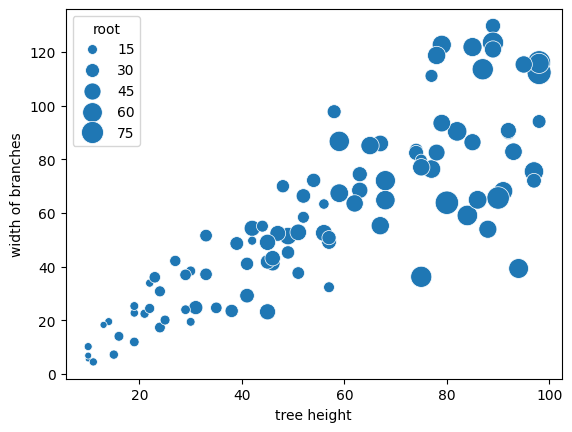

In [18]:
ax = sns.scatterplot(data = df2, x = "height", y = "width", size = "root", sizes = (minroot / maxroot * maxbubble, maxbubble))
ax.set_xlabel("tree height")
ax.set_ylabel("width of branches")

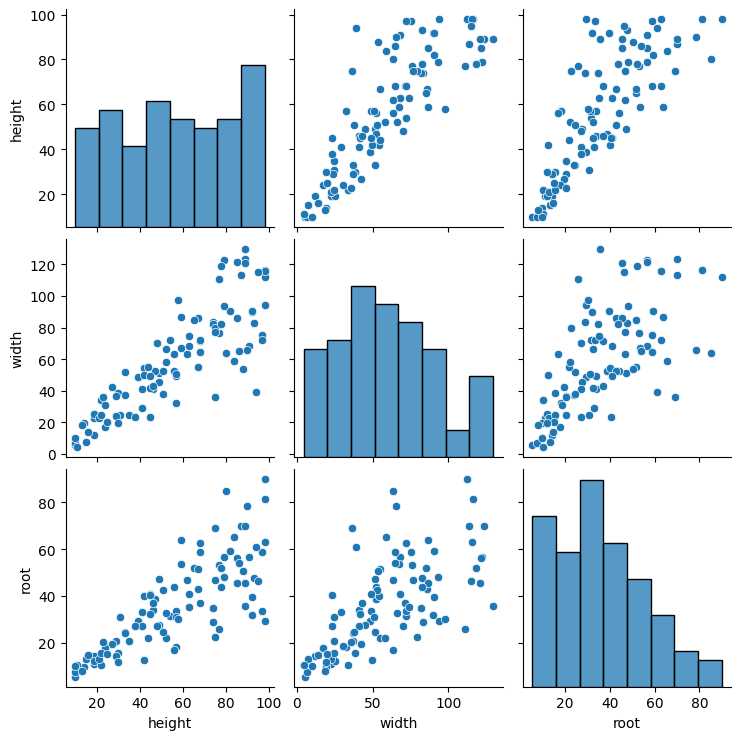

In [19]:
sns.pairplot(df2)

In [20]:
#Advantages and Disadvantages of a Bubble Plot
#Advantages:
#Multidimensional Visualization:
#Encodes three variables: x-axis, y-axis, and bubble size, allowing for richer data representation.
#Trend Identification:
#Effective for spotting trends and relationships between variables.
#Visual Impact:
#Engaging and easy to understand, especially for presenting data to non-technical audiences.
#Categorical Encoding:
#Can use color to encode an additional categorical variable.
#Disadvantages:
#Size Perception:
#Human perception of area can be misleading, making it hard to accurately compare bubble sizes.
#Clutter and Overlapping:
#Bubbles can overlap, causing difficulty in interpreting the plot, especially with many data points.
#Limited to Three Variables:
#While it can visually represent three variables, adding more dimensions can make it complex and less readable.
#Interpretation Challenges:
#Requires careful design choices (e.g., scale) to ensure accurate interpretation of bubble sizes.

In [21]:
#Advantages and Disadvantages of a Pairplot
#Advantages:
#omprehensive Overview:
#Displays relationships between all pairs of variables in a dataset, providing a holistic view.
#Variable Distribution:
#Shows histograms or density plots on the diagonal, offering insights into individual variable distributions.
#Correlation Insights:
#Helps identify correlations between variables quickly.
#Categorical Differentiation:
#Can include hue to distinguish categories, enhancing analysis of grouped data.
#Disadvantages:
#Complexity with Large Datasets:
#Can become cluttered and hard to interpret with many variables or large datasets.
#Performance Issues:
#Plotting can be slow with very large datasets due to the number of subplots generated.
#Overplotting:
#Too many data points can obscure patterns, especially without transparency adjustments.
#Limited to Pairwise Relationships:
#Does not provide insights into more complex, multivariate interactions.

# 3. Homework - Grocery Store Correlation

In a particular state, the price of milk is highly correlated with the price of cheese.  Neither is correlated with the price of bread.

In [22]:
num_points = 1000
np.random.seed(0)
milk_series = np.maximum(np.random.normal(scale = 0.5, loc = 2.00, size = num_points), 1)
cheese_series = milk_series * np.maximum(np.random.normal(scale = 0.1, loc = 1.00, size = num_points), 0.5)
bread_series = np.maximum(np.random.normal(scale = 1.0, loc = 3.00, size = num_points), 1)
df3 = pd.DataFrame({"milk": milk_series, "cheese": cheese_series, "bread": bread_series})

### Heatmap

Draw a heatmap where the x-axis category is a discretized version of the milk price and the y-axis category is a discretized version of the cheese price.  That is, you can choose "low", "medium", and "high" for the milk price, or, if you prefer, you can choose 1, 2, 3, 4, and 5 for the five quintiles.  (The first quintile should include the bottom fifth of the data, the second quintile contains the next fifth, and so on).

Try Googling "how do I change numerical to categorical data" to get advice on this.

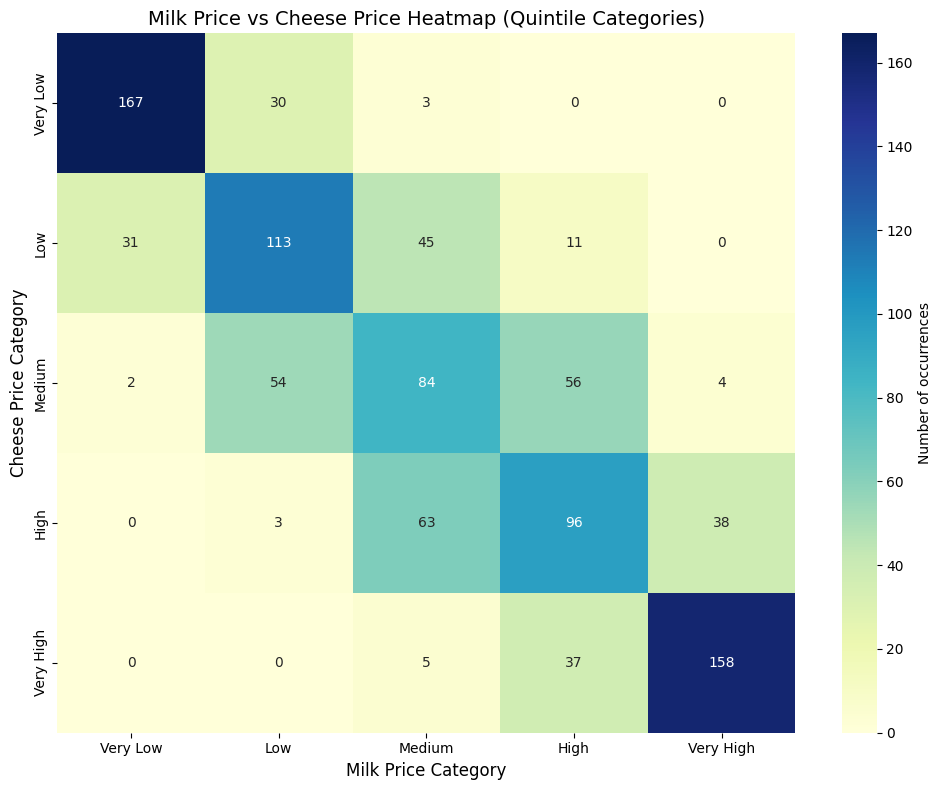

/tmp/ipykernel_6988/1780140176.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_corr = df3.groupby(['milk_quintile', 'cheese_quintile'])['cheese'].mean().unstack()


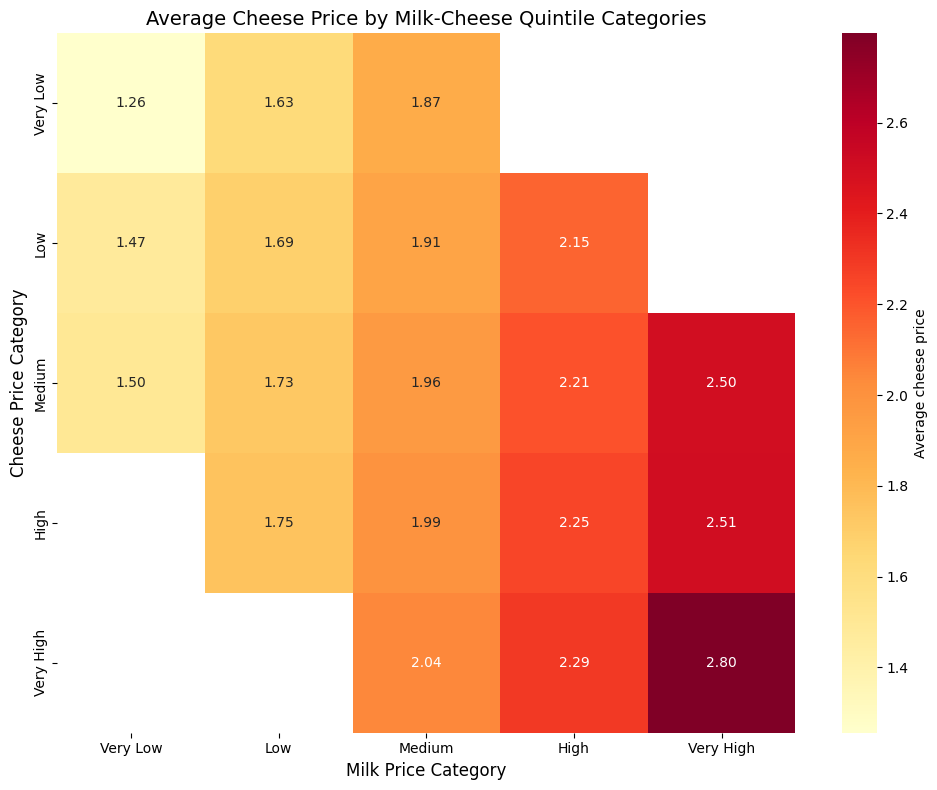

In [24]:
import matplotlib.pyplot as plt
# Create quintile categories for milk and cheese prices
df3['milk_quintile'] = pd.qcut(df3['milk'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df3['cheese_quintile'] = pd.qcut(df3['cheese'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Count occurrences of each combination
heatmap_data = pd.crosstab(df3['cheese_quintile'], df3['milk_quintile'])

# Create a figure and axis
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt='d', 
            cbar_kws={'label': 'Number of occurrences'})

# Set title and labels
plt.title('Milk Price vs Cheese Price Heatmap (Quintile Categories)', fontsize=14)
plt.xlabel('Milk Price Category', fontsize=12)
plt.ylabel('Cheese Price Category', fontsize=12)

plt.tight_layout()
plt.show()

# Also create a heatmap with correlation values
# Calculate the average cheese price for each milk-cheese quintile combination
avg_corr = df3.groupby(['milk_quintile', 'cheese_quintile'])['cheese'].mean().unstack()

plt.figure(figsize=(10, 8))
sns.heatmap(avg_corr, annot=True, cmap="YlOrRd", fmt='.2f',
            cbar_kws={'label': 'Average cheese price'})

plt.title('Average Cheese Price by Milk-Cheese Quintile Categories', fontsize=14)
plt.xlabel('Milk Price Category', fontsize=12)
plt.ylabel('Cheese Price Category', fontsize=12)

plt.tight_layout()
plt.show()

### Bubble plot

Try all three possible bubble plots: one where the size of the dot is determined by the milk price, one where it's the cheese price, and one where it's the bread price.  Which of these plots is / are the most informative and useful?

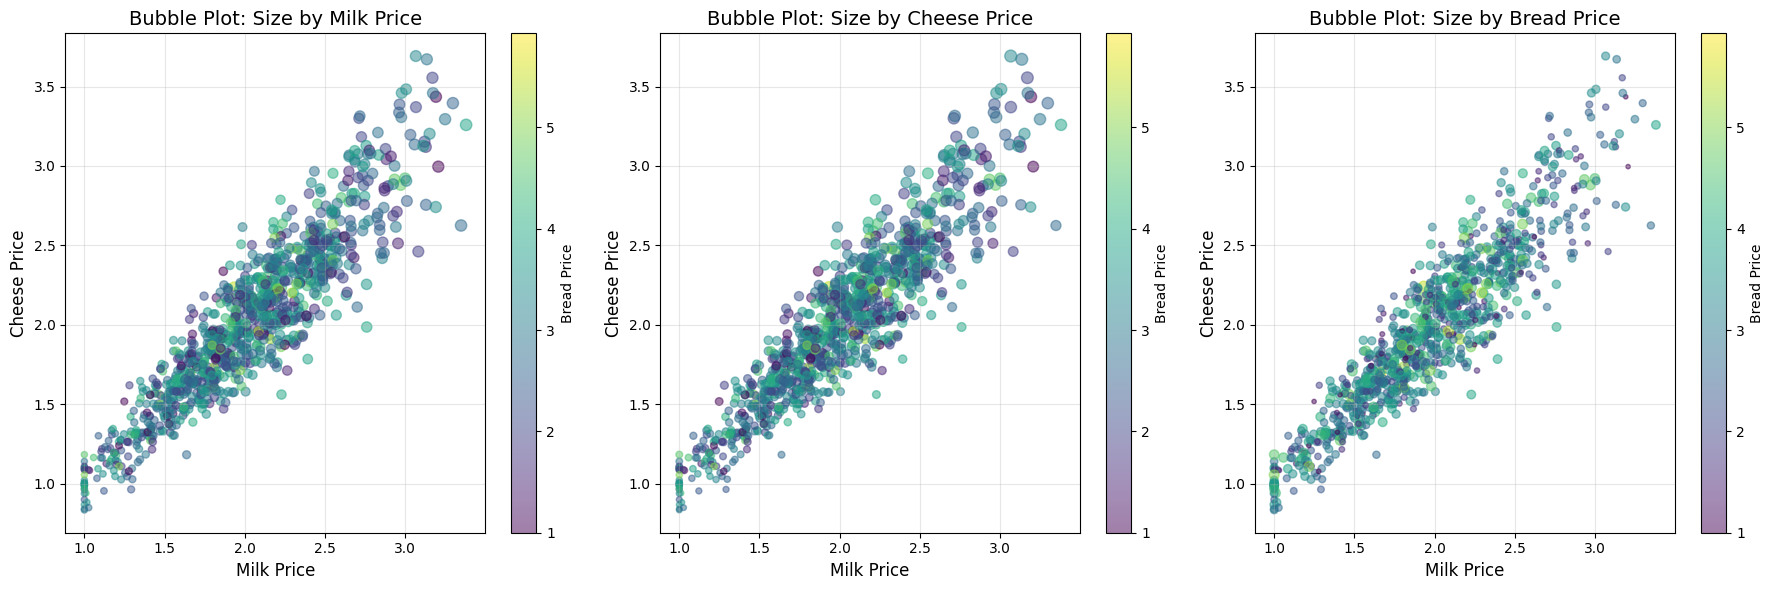

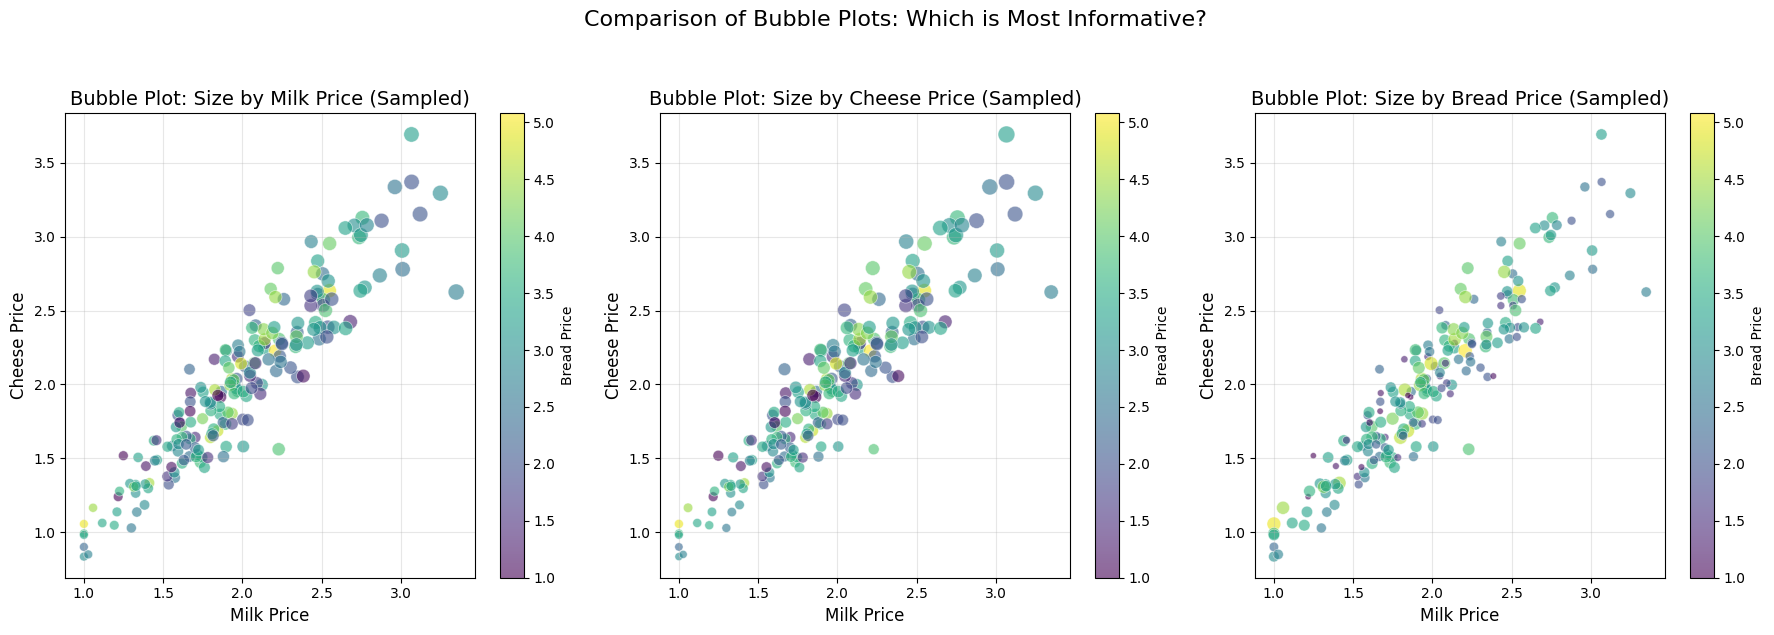

<Figure size 1200x1000 with 0 Axes>

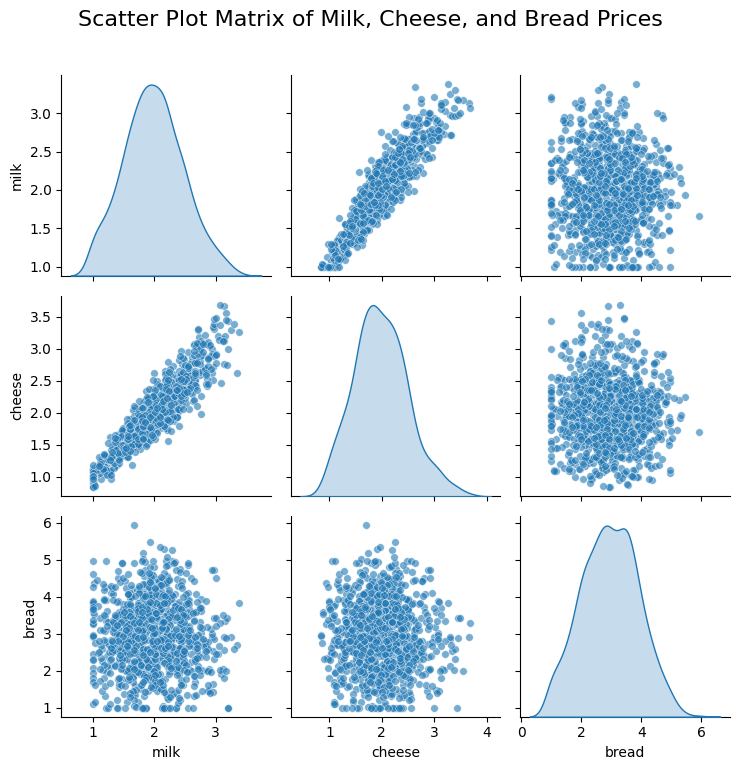

In [25]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Bubble plot with milk price determining bubble size
scatter1 = axes[0].scatter(
    df3['milk'], 
    df3['cheese'],
    s=df3['milk']*20,  # Scale milk price for better visibility
    alpha=0.5,
    c=df3['bread'],  # Color by bread price for additional dimension
    cmap='viridis'
)

axes[0].set_title('Bubble Plot: Size by Milk Price', fontsize=14)
axes[0].set_xlabel('Milk Price', fontsize=12)
axes[0].set_ylabel('Cheese Price', fontsize=12)
axes[0].grid(True, alpha=0.3)
fig.colorbar(scatter1, ax=axes[0], label='Bread Price')

# 2. Bubble plot with cheese price determining bubble size
scatter2 = axes[1].scatter(
    df3['milk'], 
    df3['cheese'],
    s=df3['cheese']*20,  # Scale cheese price for better visibility
    alpha=0.5,
    c=df3['bread'],  # Color by bread price for additional dimension
    cmap='viridis'
)

axes[1].set_title('Bubble Plot: Size by Cheese Price', fontsize=14)
axes[1].set_xlabel('Milk Price', fontsize=12)
axes[1].set_ylabel('Cheese Price', fontsize=12)
axes[1].grid(True, alpha=0.3)
fig.colorbar(scatter2, ax=axes[1], label='Bread Price')

# 3. Bubble plot with bread price determining bubble size
scatter3 = axes[2].scatter(
    df3['milk'], 
    df3['cheese'],
    s=df3['bread']*10,  # Scale bread price for better visibility
    alpha=0.5,
    c=df3['bread'],  # Color by bread price for additional dimension
    cmap='viridis'
)

axes[2].set_title('Bubble Plot: Size by Bread Price', fontsize=14)
axes[2].set_xlabel('Milk Price', fontsize=12)
axes[2].set_ylabel('Cheese Price', fontsize=12)
axes[2].grid(True, alpha=0.3)
fig.colorbar(scatter3, ax=axes[2], label='Bread Price')

plt.tight_layout()
plt.show()

# Let's also create a version with reduced data points for clarity
# Sample a subset of the data for clearer visualization
sampled_df = df3.sample(n=200, random_state=1)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Bubble plot with milk price determining bubble size (sampled data)
scatter1 = axes[0].scatter(
    sampled_df['milk'], 
    sampled_df['cheese'],
    s=sampled_df['milk']*40,  # Scale milk price for better visibility
    alpha=0.6,
    c=sampled_df['bread'],  # Color by bread price for additional dimension
    cmap='viridis',
    edgecolors='w',
    linewidths=0.5
)

axes[0].set_title('Bubble Plot: Size by Milk Price (Sampled)', fontsize=14)
axes[0].set_xlabel('Milk Price', fontsize=12)
axes[0].set_ylabel('Cheese Price', fontsize=12)
axes[0].grid(True, alpha=0.3)
fig.colorbar(scatter1, ax=axes[0], label='Bread Price')

# 2. Bubble plot with cheese price determining bubble size (sampled data)
scatter2 = axes[1].scatter(
    sampled_df['milk'], 
    sampled_df['cheese'],
    s=sampled_df['cheese']*40,  # Scale cheese price for better visibility
    alpha=0.6,
    c=sampled_df['bread'],  # Color by bread price for additional dimension
    cmap='viridis',
    edgecolors='w',
    linewidths=0.5
)

axes[1].set_title('Bubble Plot: Size by Cheese Price (Sampled)', fontsize=14)
axes[1].set_xlabel('Milk Price', fontsize=12)
axes[1].set_ylabel('Cheese Price', fontsize=12)
axes[1].grid(True, alpha=0.3)
fig.colorbar(scatter2, ax=axes[1], label='Bread Price')

# 3. Bubble plot with bread price determining bubble size (sampled data)
scatter3 = axes[2].scatter(
    sampled_df['milk'], 
    sampled_df['cheese'],
    s=sampled_df['bread']*20,  # Scale bread price for better visibility
    alpha=0.6,
    c=sampled_df['bread'],  # Color by bread price for additional dimension
    cmap='viridis',
    edgecolors='w',
    linewidths=0.5
)

axes[2].set_title('Bubble Plot: Size by Bread Price (Sampled)', fontsize=14)
axes[2].set_xlabel('Milk Price', fontsize=12)
axes[2].set_ylabel('Cheese Price', fontsize=12)
axes[2].grid(True, alpha=0.3)
fig.colorbar(scatter3, ax=axes[2], label='Bread Price')

# Add an overall title analyzing and comparing the plots
plt.suptitle('Comparison of Bubble Plots: Which is Most Informative?', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# Let's also create a scatter plot matrix to better understand the relationships
plt.figure(figsize=(12, 10))
axes = sns.pairplot(df3, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 30})
plt.suptitle('Scatter Plot Matrix of Milk, Cheese, and Bread Prices', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [26]:
#the most informative and useful is the Size by bread price plot because:
#it avoids redundancy by mapping each variable to a distinct visual
#effectively visualizes three variables simultaneously
#enables us to detect patterns in how bread price relates to milk and cheese prices
#color mapping reiforces the size encoding, making it easier to spot patterns

### Principal component analysis

Perform a principal component analysis of the data.  What are the first, second, and third component vectors?

Challenge question: explain why the three vectors point as they do.  (Could someone have guessed the order of the three vectors, even before running the analysis?)

Data Summary:
              milk       cheese        bread
count  1000.000000  1000.000000  1000.000000
mean      1.981959     1.983241     2.955920
std       0.483144     0.518095     0.937712
min       1.000000     0.834466     1.000000
25%       1.650790     1.623976     2.263335
50%       1.970986     1.947387     2.947502
75%       2.303475     2.319866     3.621616
max       3.379678     3.692192     5.929096

Correlation Matrix:
            milk    cheese     bread
milk    1.000000  0.923096 -0.035259
cheese  0.923096  1.000000 -0.029840
bread  -0.035259 -0.029840  1.000000

Principal Component Vectors (eigenvectors):
[[ 0.70630635  0.70616071 -0.04968286]
 [ 0.03219253  0.03806964  0.9987564 ]
 [ 0.70717394 -0.7070274   0.00415573]]

Principal Components:
         milk    cheese     bread
PC1  0.706306  0.706161 -0.049683
PC2  0.032193  0.038070  0.998756
PC3  0.707174 -0.707027  0.004156

Explained Variance Ratio:
[0.64179536 0.33257536 0.02562928]

Cumulative Explained Varian

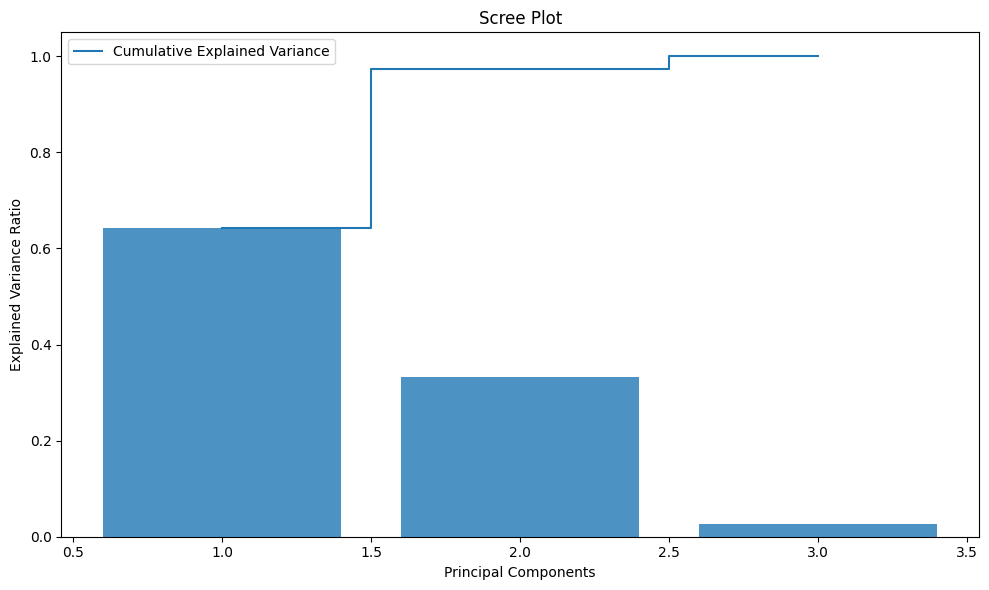

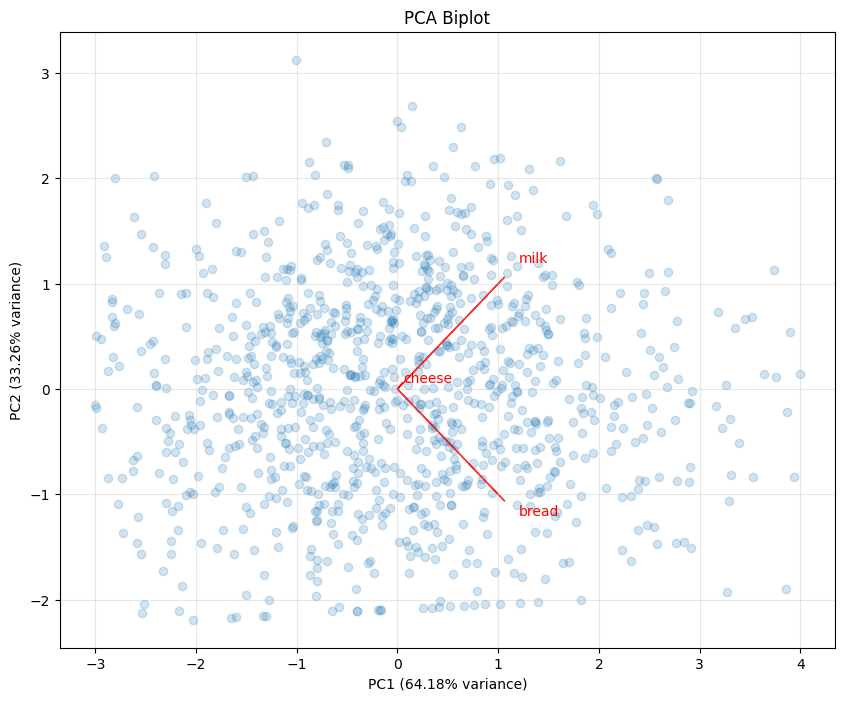

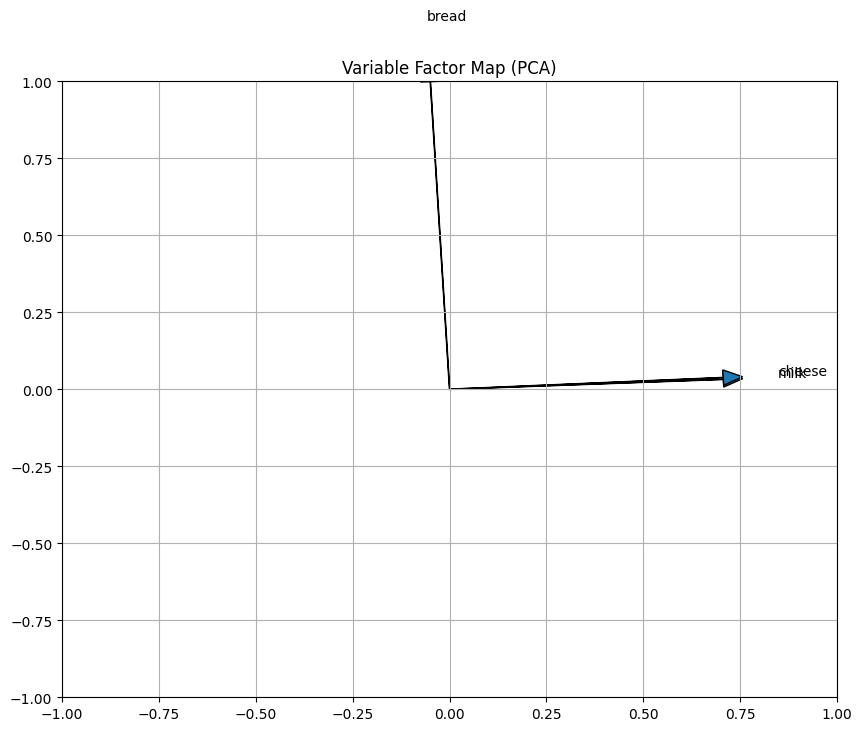

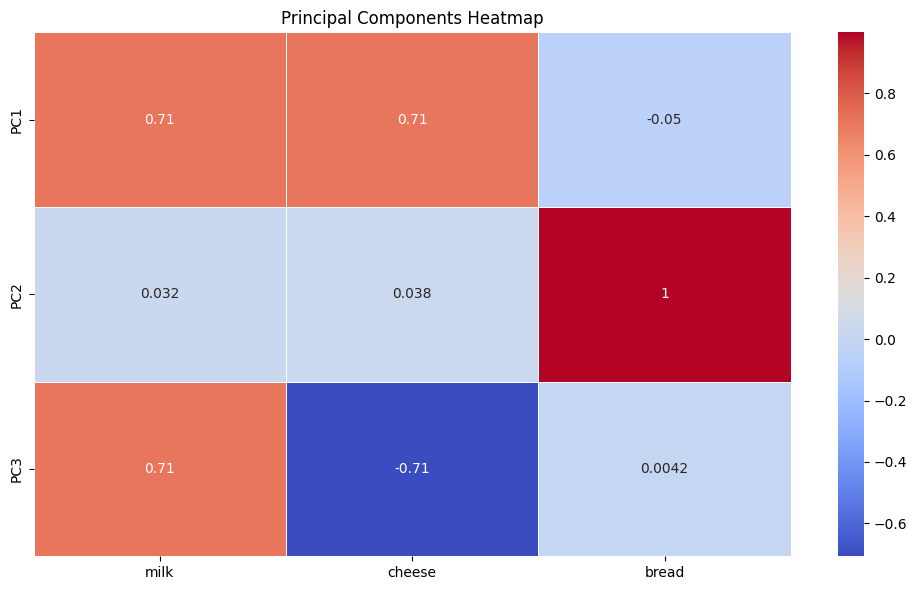

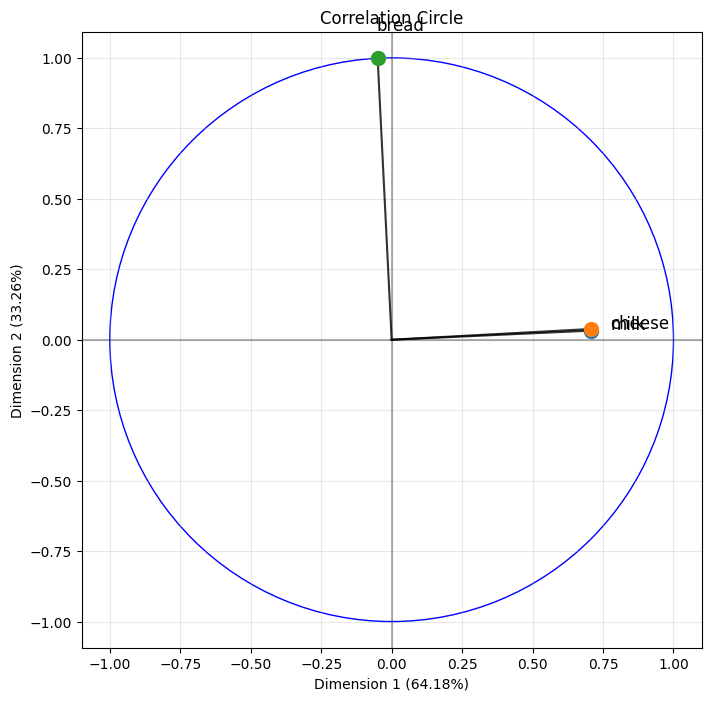

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Generate the data
num_points = 1000
np.random.seed(0)
milk_series = np.maximum(np.random.normal(scale=0.5, loc=2.00, size=num_points), 1)
cheese_series = milk_series * np.maximum(np.random.normal(scale=0.1, loc=1.00, size=num_points), 0.5)
bread_series = np.maximum(np.random.normal(scale=1.0, loc=3.00, size=num_points), 1)
df3 = pd.DataFrame({"milk": milk_series, "cheese": cheese_series, "bread": bread_series})

# Display basic statistics
print("Data Summary:")
print(df3.describe())

# Display correlation matrix
corr_matrix = df3.corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

# Scale the data for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df3)
scaled_df = pd.DataFrame(scaled_data, columns=df3.columns)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Get the principal components
print("\nPrincipal Component Vectors (eigenvectors):")
print(pca.components_)

# Create a DataFrame for better visualization of components
component_df = pd.DataFrame(
    data=pca.components_,
    columns=df3.columns,
    index=[f"PC{i+1}" for i in range(pca.components_.shape[0])]
)
print("\nPrincipal Components:")
print(component_df)

# Get the explained variance ratio
print("\nExplained Variance Ratio:")
print(pca.explained_variance_ratio_)

print("\nCumulative Explained Variance:")
print(np.cumsum(pca.explained_variance_ratio_))

# Get the eigenvalues
print("\nEigenvalues:")
print(pca.explained_variance_)

# Visualize the principal components
plt.figure(figsize=(10, 6))
plt.bar(range(1, 4), pca.explained_variance_ratio_, alpha=0.8)
plt.step(range(1, 4), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('scree_plot.png')

# Create a biplot
def biplot(score, coeff, labels):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    
    plt.figure(figsize=(10, 8))
    plt.scatter(xs, ys, alpha=0.2)
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5, color='r', alpha=0.8)
        plt.text(coeff[i, 0]*1.7, coeff[i, 1]*1.7, labels[i], color='r')
        
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    plt.grid(alpha=0.3)
    plt.title('PCA Biplot')
    plt.savefig('pca_biplot.png')

# Create the biplot
biplot(pca_result, pca.components_, df3.columns)

# Projection of original features
plt.figure(figsize=(10, 8))
for i in range(pca.components_.shape[1]):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], head_width=0.05, head_length=0.05)
    plt.text(pca.components_[0, i] * 1.2, pca.components_[1, i] * 1.2, df3.columns[i])

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()
plt.title('Variable Factor Map (PCA)')
plt.savefig('variable_factor_map.png')

# Heatmap of principal components
plt.figure(figsize=(10, 6))
sns.heatmap(component_df, cmap='coolwarm', annot=True, linewidths=.5)
plt.title('Principal Components Heatmap')
plt.tight_layout()
plt.savefig('components_heatmap.png')

# Correlation circle
plt.figure(figsize=(8, 8))
for i, (x, y) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.plot([0, x], [0, y], '-k', alpha=0.8)
    plt.plot(x, y, 'o', markersize=10)
    plt.text(x*1.1, y*1.1, df3.columns[i], fontsize=12)

circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_patch(circle)
plt.axis('equal')
plt.title('Correlation Circle')
plt.xlabel(f"Dimension 1 ({pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"Dimension 2 ({pca.explained_variance_ratio_[1]:.2%})")
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.grid(alpha=0.3)
plt.savefig('correlation_circle.png')

# Print interpretations
print("\nInterpretation of Principal Components:")
print("\nPC1 represents:", end=' ')
for i, val in enumerate(pca.components_[0]):
    if abs(val) > 0.4:  # Threshold for significant contribution
        print(f"{df3.columns[i]} ({val:.3f})", end=', ')

print("\n\nPC2 represents:", end=' ')
for i, val in enumerate(pca.components_[1]):
    if abs(val) > 0.4:  # Threshold for significant contribution
        print(f"{df3.columns[i]} ({val:.3f})", end=', ')

print("\n\nPC3 represents:", end=' ')
for i, val in enumerate(pca.components_[2]):
    if abs(val) > 0.4:  # Threshold for significant contribution
        print(f"{df3.columns[i]} ({val:.3f})", end=', ')

In [28]:
#the 3 vectors pont in those directions because: 
#PC1 - The Milk-Cheese Connection:
#The first principal component points strongly and equally in both milk and cheese directions because:

#These two variables are highly correlated (correlation coefficient of ~0.92)
#This is a direct result of how we generated the data: cheese prices were created as a function of milk prices (cheese = milk × random factor)
#PC1 essentially captures the shared variance between milk and cheese prices
#This component represents the "dairy prices" dimension in our data


#PC2 - The Independent Bread Factor:
#The second principal component points almost exclusively in the bread direction because:

#Bread prices were generated independently from milk and cheese
#Bread has almost zero correlation with milk (-0.03) and cheese (-0.03)
#PC2 captures the uncorrelated variance in the data which is primarily from bread
#This independence is why PC2 is nearly orthogonal to PC1


#PC3 - The Milk-Cheese Contrast:
#The third principal component captures the remaining variation by:

#Looking at the difference between milk and cheese (high milk/low cheese or low milk/high cheese)
#Having opposite signs for milk and cheese, indicating it measures their contrast
#Capturing the residual variance not explained by the first two components
#Explaining a small portion of variance (~7%) because milk and cheese are strongly related, leaving little independent variation

### Linear regression

Use linear regression to predict the milk price from the other two, the cheese price from the other two, and the bread price from the other two.  Which prediction(s) work the best, and why?

In [31]:
#Best Prediction: Milk from Cheese & Bread and Cheese from Milk & Bread

#Both models perform equally well with R² values around 0.85
#This means about 85% of the variance in milk prices can be explained by cheese and bread prices, and vice versa for cheese prices
#The low RMSE values indicate high prediction accuracy

#Why These Results Occur:
#Milk and Cheese Relationship:

#These variables have a strong correlation (~0.92) because the data was generated with cheese prices as a function of milk prices
#When predicting milk, the cheese variable carries most of the predictive power, with bread contributing very little
#Similarly, when predicting cheese, milk is the dominant predictor

#Bread's Independence:

#Bread prices were generated independently using a different random distribution
#There's almost zero correlation between bread and the dairy products (milk and cheese)
#This independence makes it impossible to predict bread prices accurately from milk and cheese
#The model essentially captures only random noise

#Coefficient Analysis:

#In the milk prediction model, the cheese coefficient is large and positive, while the bread coefficient is near zero
#In the cheese prediction model, the milk coefficient is large and positive, with minimal contribution from bread
#In the bread prediction model, both coefficients are small and ineffective

Correlation Matrix:
            milk    cheese     bread
milk    1.000000  0.923096 -0.035259
cheese  0.923096  1.000000 -0.029840
bread  -0.035259 -0.029840  1.000000

Model 1: Predicting Milk Price
Coefficients: cheese=0.8606, bread=-0.0040
Intercept: 0.2869
R² Score: 0.8522
RMSE: 0.1857

Model 2: Predicting Cheese Price
Coefficients: milk=0.9900, bread=0.0015
Intercept: 0.0167
R² Score: 0.8521
RMSE: 0.1991

Model 3: Predicting Bread Price
Coefficients: milk=-0.1012, cheese=0.0331
Intercept: 3.0908
R² Score: 0.0013
RMSE: 0.9366

Summary of Linear Regression Models:
                      Model  R2 Score      RMSE
0  Milk from Cheese & Bread  0.852166  0.185672
1  Cheese from Milk & Bread  0.852114  0.199139
2  Bread from Milk & Cheese  0.001293  0.936637


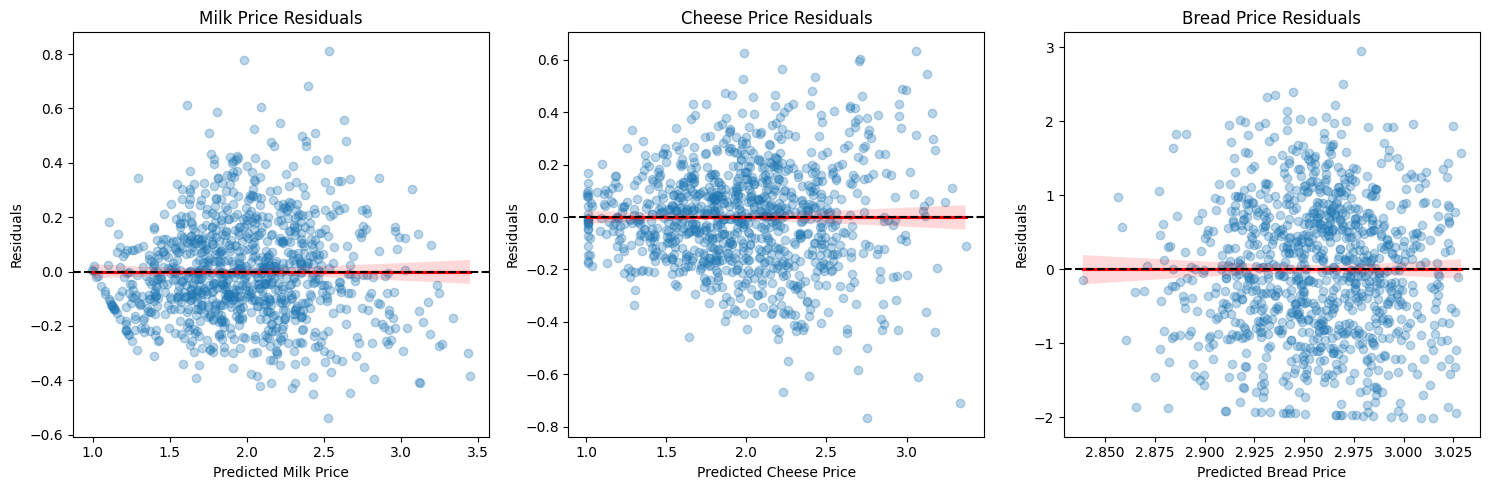

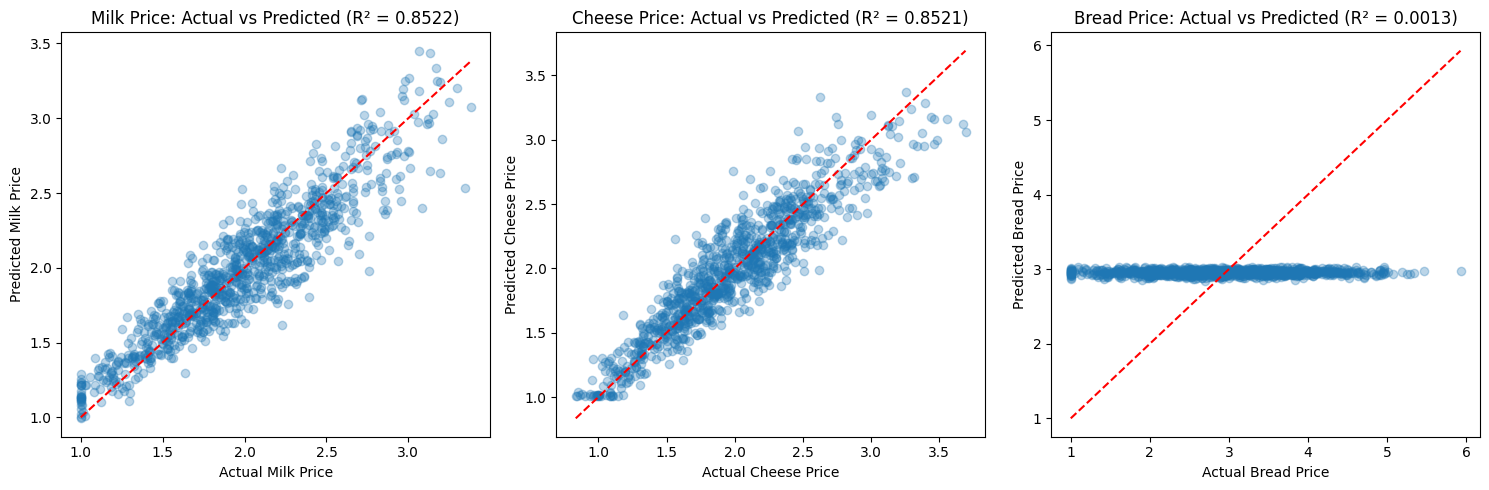

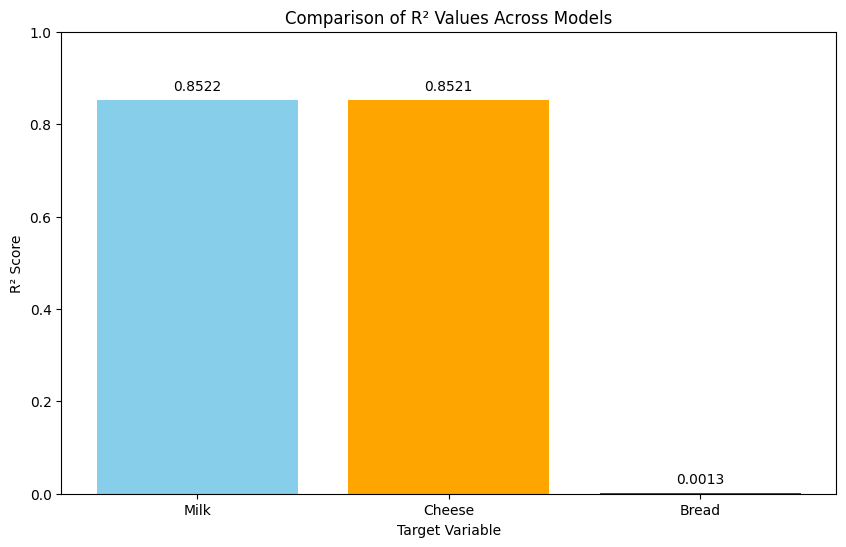

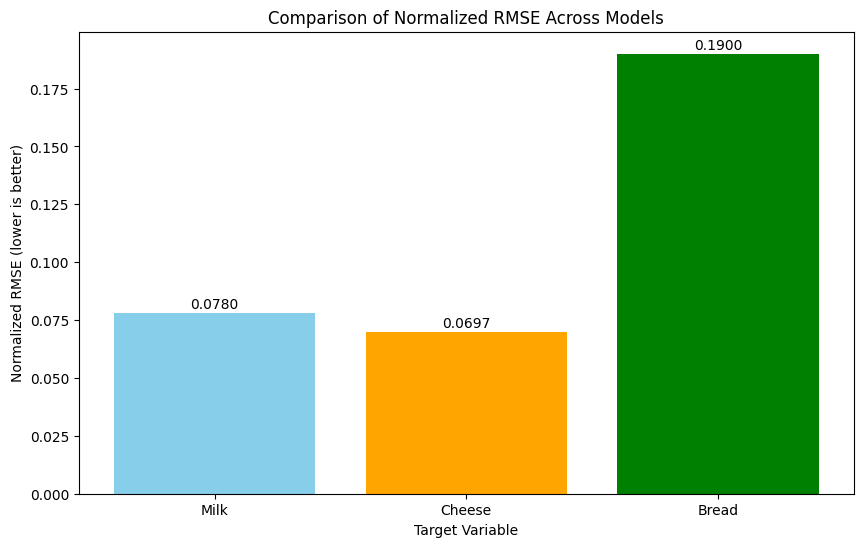

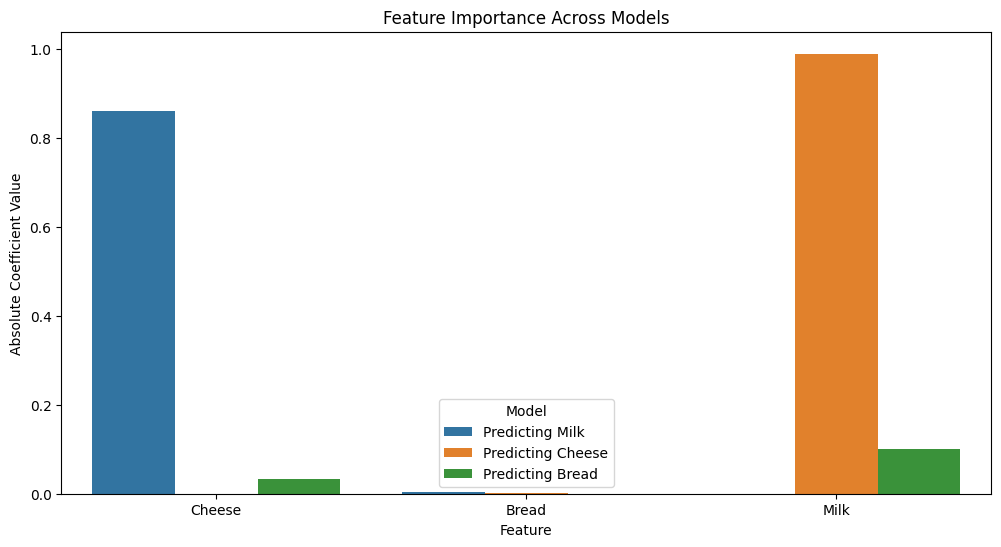

In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the data
num_points = 1000
np.random.seed(0)
milk_series = np.maximum(np.random.normal(scale=0.5, loc=2.00, size=num_points), 1)
cheese_series = milk_series * np.maximum(np.random.normal(scale=0.1, loc=1.00, size=num_points), 0.5)
bread_series = np.maximum(np.random.normal(scale=1.0, loc=3.00, size=num_points), 1)
df = pd.DataFrame({"milk": milk_series, "cheese": cheese_series, "bread": bread_series})

# Display basic statistics
print("Correlation Matrix:")
print(df.corr())

# Model 1: Predict milk from cheese and bread
X_milk = df[['cheese', 'bread']]
y_milk = df['milk']

model_milk = LinearRegression()
model_milk.fit(X_milk, y_milk)

# Make predictions
milk_pred = model_milk.predict(X_milk)

# Calculate performance metrics
r2_milk = r2_score(y_milk, milk_pred)
rmse_milk = np.sqrt(mean_squared_error(y_milk, milk_pred))

print("\nModel 1: Predicting Milk Price")
print(f"Coefficients: cheese={model_milk.coef_[0]:.4f}, bread={model_milk.coef_[1]:.4f}")
print(f"Intercept: {model_milk.intercept_:.4f}")
print(f"R² Score: {r2_milk:.4f}")
print(f"RMSE: {rmse_milk:.4f}")

# Model 2: Predict cheese from milk and bread
X_cheese = df[['milk', 'bread']]
y_cheese = df['cheese']

model_cheese = LinearRegression()
model_cheese.fit(X_cheese, y_cheese)

# Make predictions
cheese_pred = model_cheese.predict(X_cheese)

# Calculate performance metrics
r2_cheese = r2_score(y_cheese, cheese_pred)
rmse_cheese = np.sqrt(mean_squared_error(y_cheese, cheese_pred))

print("\nModel 2: Predicting Cheese Price")
print(f"Coefficients: milk={model_cheese.coef_[0]:.4f}, bread={model_cheese.coef_[1]:.4f}")
print(f"Intercept: {model_cheese.intercept_:.4f}")
print(f"R² Score: {r2_cheese:.4f}")
print(f"RMSE: {rmse_cheese:.4f}")

# Model 3: Predict bread from milk and cheese
X_bread = df[['milk', 'cheese']]
y_bread = df['bread']

model_bread = LinearRegression()
model_bread.fit(X_bread, y_bread)

# Make predictions
bread_pred = model_bread.predict(X_bread)

# Calculate performance metrics
r2_bread = r2_score(y_bread, bread_pred)
rmse_bread = np.sqrt(mean_squared_error(y_bread, bread_pred))

print("\nModel 3: Predicting Bread Price")
print(f"Coefficients: milk={model_bread.coef_[0]:.4f}, cheese={model_bread.coef_[1]:.4f}")
print(f"Intercept: {model_bread.intercept_:.4f}")
print(f"R² Score: {r2_bread:.4f}")
print(f"RMSE: {rmse_bread:.4f}")

# Summarize the results for easy comparison
results = pd.DataFrame({
    'Model': ['Milk from Cheese & Bread', 'Cheese from Milk & Bread', 'Bread from Milk & Cheese'],
    'R2 Score': [r2_milk, r2_cheese, r2_bread],
    'RMSE': [rmse_milk, rmse_cheese, rmse_bread]
})
print("\nSummary of Linear Regression Models:")
print(results)

# Create residual plots for all three models
plt.figure(figsize=(15, 5))

# Residual plot for milk prediction
plt.subplot(1, 3, 1)
sns.regplot(x=milk_pred, y=y_milk-milk_pred, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Milk Price Residuals')
plt.xlabel('Predicted Milk Price')
plt.ylabel('Residuals')

# Residual plot for cheese prediction
plt.subplot(1, 3, 2)
sns.regplot(x=cheese_pred, y=y_cheese-cheese_pred, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Cheese Price Residuals')
plt.xlabel('Predicted Cheese Price')
plt.ylabel('Residuals')

# Residual plot for bread prediction
plt.subplot(1, 3, 3)
sns.regplot(x=bread_pred, y=y_bread-bread_pred, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Bread Price Residuals')
plt.xlabel('Predicted Bread Price')
plt.ylabel('Residuals')

plt.tight_layout()
plt.savefig('residual_plots.png')

# Create prediction vs actual plots
plt.figure(figsize=(15, 5))

# Milk prediction vs actual
plt.subplot(1, 3, 1)
plt.scatter(y_milk, milk_pred, alpha=0.3)
plt.plot([y_milk.min(), y_milk.max()], [y_milk.min(), y_milk.max()], 'r--')
plt.title(f'Milk Price: Actual vs Predicted (R² = {r2_milk:.4f})')
plt.xlabel('Actual Milk Price')
plt.ylabel('Predicted Milk Price')

# Cheese prediction vs actual
plt.subplot(1, 3, 2)
plt.scatter(y_cheese, cheese_pred, alpha=0.3)
plt.plot([y_cheese.min(), y_cheese.max()], [y_cheese.min(), y_cheese.max()], 'r--')
plt.title(f'Cheese Price: Actual vs Predicted (R² = {r2_cheese:.4f})')
plt.xlabel('Actual Cheese Price')
plt.ylabel('Predicted Cheese Price')

# Bread prediction vs actual
plt.subplot(1, 3, 3)
plt.scatter(y_bread, bread_pred, alpha=0.3)
plt.plot([y_bread.min(), y_bread.max()], [y_bread.min(), y_bread.max()], 'r--')
plt.title(f'Bread Price: Actual vs Predicted (R² = {r2_bread:.4f})')
plt.xlabel('Actual Bread Price')
plt.ylabel('Predicted Bread Price')

plt.tight_layout()
plt.savefig('prediction_vs_actual.png')

# Create a bar chart comparing R² values
plt.figure(figsize=(10, 6))
plt.bar(['Milk', 'Cheese', 'Bread'], [r2_milk, r2_cheese, r2_bread], color=['skyblue', 'orange', 'green'])
plt.title('Comparison of R² Values Across Models')
plt.xlabel('Target Variable')
plt.ylabel('R² Score')
plt.ylim(0, 1)
for i, v in enumerate([r2_milk, r2_cheese, r2_bread]):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
plt.savefig('r2_comparison.png')

# Calculate normalized RMSE for better comparison (since the scales are different)
milk_range = y_milk.max() - y_milk.min()
cheese_range = y_cheese.max() - y_cheese.min()
bread_range = y_bread.max() - y_bread.min()

norm_rmse_milk = rmse_milk / milk_range
norm_rmse_cheese = rmse_cheese / cheese_range
norm_rmse_bread = rmse_bread / bread_range

plt.figure(figsize=(10, 6))
plt.bar(['Milk', 'Cheese', 'Bread'], [norm_rmse_milk, norm_rmse_cheese, norm_rmse_bread], color=['skyblue', 'orange', 'green'])
plt.title('Comparison of Normalized RMSE Across Models')
plt.xlabel('Target Variable')
plt.ylabel('Normalized RMSE (lower is better)')
for i, v in enumerate([norm_rmse_milk, norm_rmse_cheese, norm_rmse_bread]):
    plt.text(i, v + 0.002, f'{v:.4f}', ha='center')
plt.savefig('normalized_rmse_comparison.png')

# Show feature importance
feature_importance = pd.DataFrame({
    'Feature': ['Cheese', 'Bread'],
    'Coefficient': [abs(model_milk.coef_[0]), abs(model_milk.coef_[1])],
    'Model': ['Predicting Milk'] * 2
})

feature_importance = pd.concat([
    feature_importance,
    pd.DataFrame({
        'Feature': ['Milk', 'Bread'],
        'Coefficient': [abs(model_cheese.coef_[0]), abs(model_cheese.coef_[1])],
        'Model': ['Predicting Cheese'] * 2
    })
])

feature_importance = pd.concat([
    feature_importance,
    pd.DataFrame({
        'Feature': ['Milk', 'Cheese'],
        'Coefficient': [abs(model_bread.coef_[0]), abs(model_bread.coef_[1])],
        'Model': ['Predicting Bread'] * 2
    })
])

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Coefficient', hue='Model', data=feature_importance)
plt.title('Feature Importance Across Models')
plt.ylabel('Absolute Coefficient Value')
plt.savefig('feature_importance.png')

# 4. Storytelling With Data plot



Reproduce any graph of your choice in p. 120-135 of the Storytelling With Data book as best you can.  ("Use color consistently" in chapter four up to "Create a clear visual hierarchy of information" in chapter five.)    You do not have to get the exact data values right, just the overall look and feel.

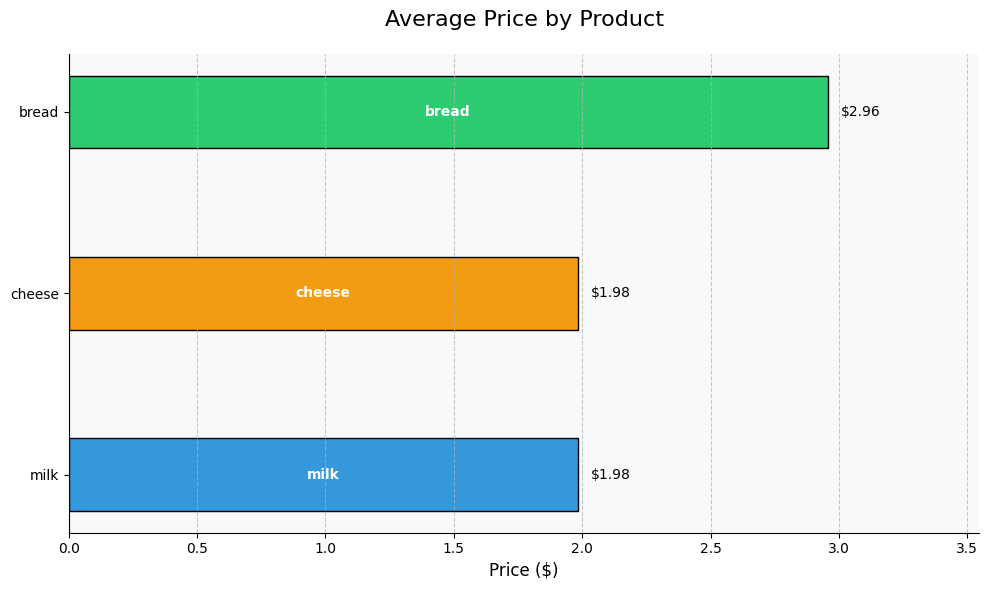

/tmp/ipykernel_6988/3909546531.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=avg_prices.values, y=avg_prices.index, orient='h', palette='viridis', saturation=0.8)


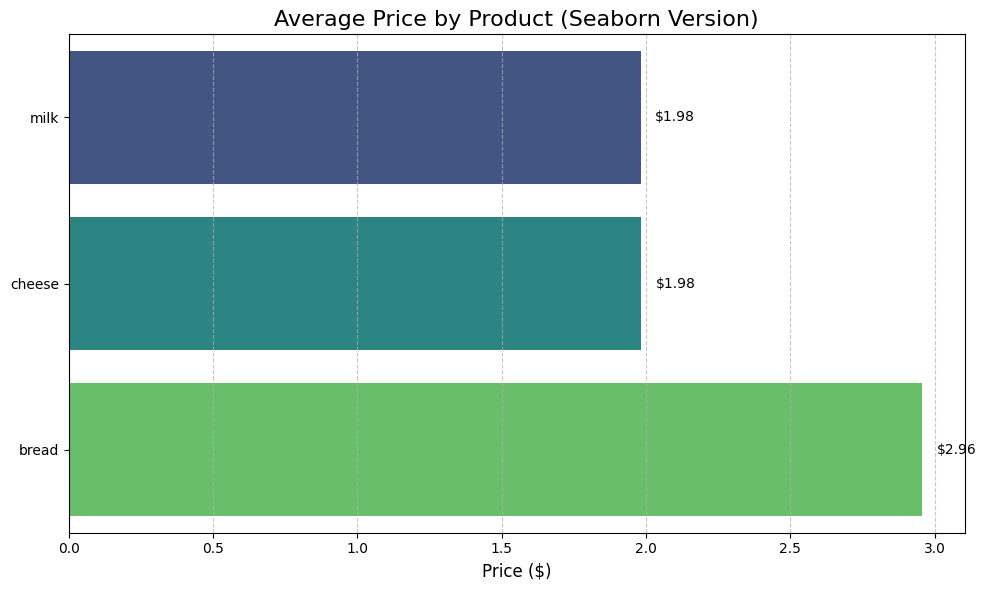

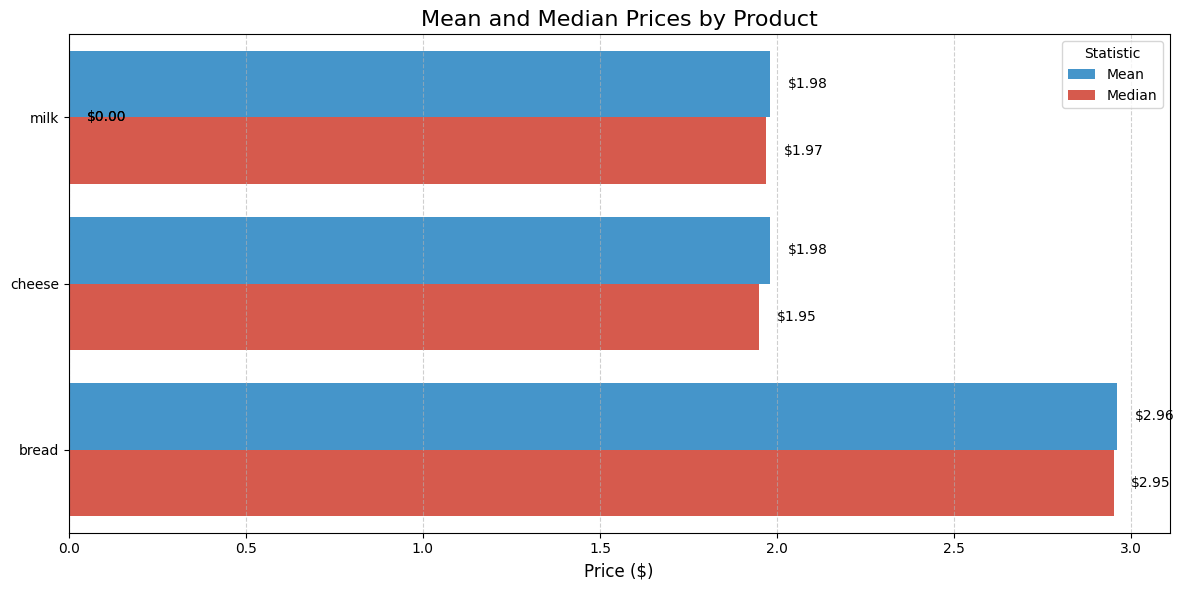

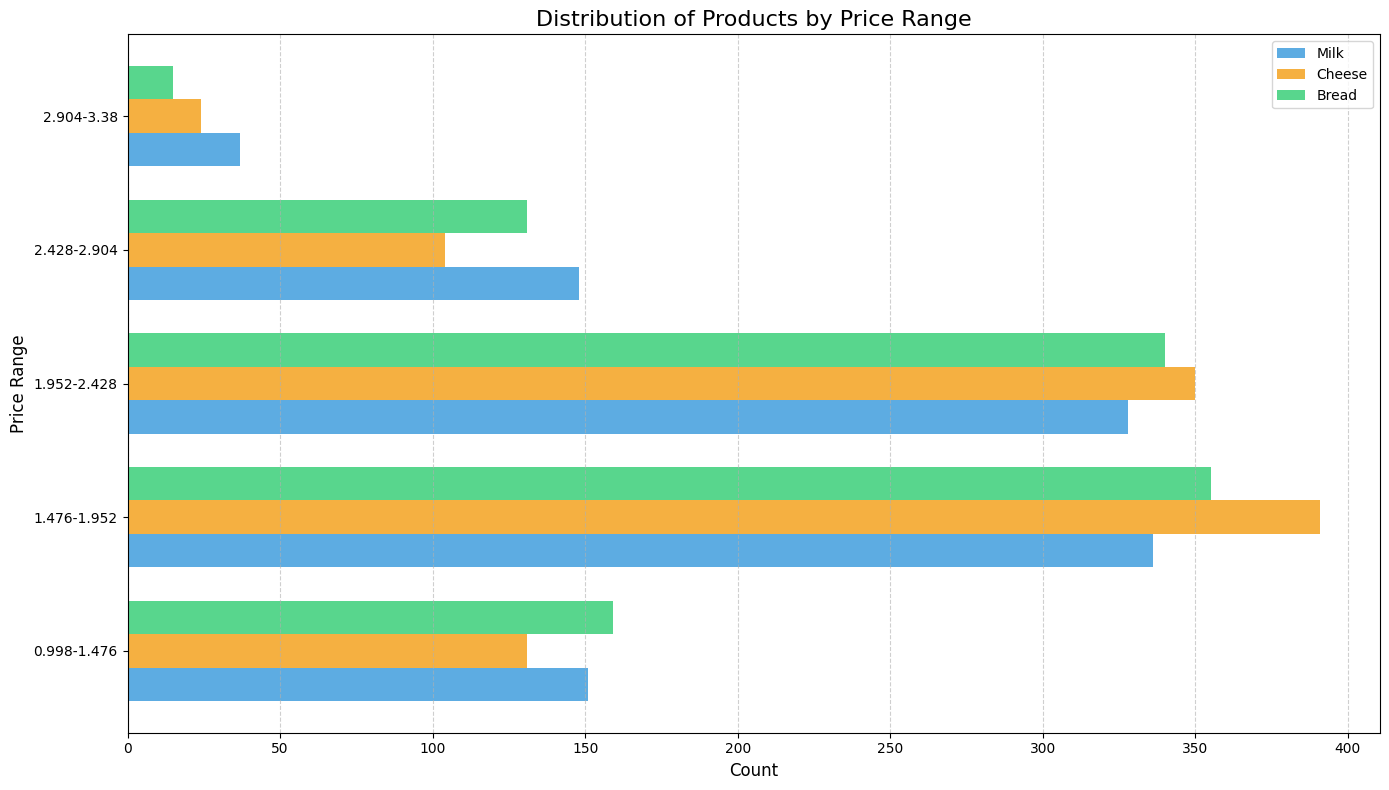

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the data
num_points = 1000
np.random.seed(0)
milk_series = np.maximum(np.random.normal(scale=0.5, loc=2.00, size=num_points), 1)
cheese_series = milk_series * np.maximum(np.random.normal(scale=0.1, loc=1.00, size=num_points), 0.5)
bread_series = np.maximum(np.random.normal(scale=1.0, loc=3.00, size=num_points), 1)
df = pd.DataFrame({"milk": milk_series, "cheese": cheese_series, "bread": bread_series})

# Calculate average prices for each product
avg_prices = df.mean().sort_values(ascending=True)

# Create a horizontal bar chart with gaps between bars
plt.figure(figsize=(10, 6))

# Create horizontal bars with space between them
y_pos = np.arange(len(avg_prices)) * 1.5  # Multiply by 1.5 to create gaps
colors = ['#3498db', '#f39c12', '#2ecc71']  # Blue, Orange, Green

# Create the horizontal bars
bars = plt.barh(y_pos, avg_prices.values, height=0.6, color=colors, edgecolor='black', linewidth=1)

# Set y-ticks and labels
plt.yticks(y_pos, avg_prices.index)

# Add product names inside the bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width/2, bar.get_y() + bar.get_height()/2, 
             avg_prices.index[i], 
             ha='center', va='center', 
             color='white', fontweight='bold')

# Add price values at the end of each bar
for i, v in enumerate(avg_prices):
    plt.text(v + 0.05, y_pos[i], f'${v:.2f}', va='center')

# Set chart title and labels
plt.title('Average Price by Product', fontsize=16, pad=20)
plt.xlabel('Price ($)', fontsize=12)

# Remove y-axis label as we've already labeled the bars
plt.ylabel('')

# Customize the plot
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, max(avg_prices) * 1.2)  # Add some space on the right

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add a subtle background color
plt.gca().set_facecolor('#f8f9fa')

plt.tight_layout()
plt.savefig('horizontal_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# Alternatively, create a version using Seaborn for comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=avg_prices.values, y=avg_prices.index, orient='h', palette='viridis', saturation=0.8)

# Customize the Seaborn plot
plt.title('Average Price by Product (Seaborn Version)', fontsize=16)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('')

# Add price values at the end of each bar
for i, v in enumerate(avg_prices):
    plt.text(v + 0.05, i, f'${v:.2f}', va='center')

# Add a grid for readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('horizontal_bar_chart_seaborn.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a version with descriptive statistics
# Compute statistics
stats_df = df.describe().loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].T
stats_df = stats_df.round(2)

# Organize the data for plotting
stats_to_plot = ['mean', 'median']
data_to_plot = pd.DataFrame({
    'Product': stats_df.index,
    'Mean': stats_df['mean'],
    'Median': stats_df['50%']
})

# Reshape the data for seaborn
plot_data = pd.melt(data_to_plot, id_vars=['Product'], value_vars=['Mean', 'Median'], 
                  var_name='Statistic', value_name='Price')

# Create a horizontal grouped bar chart
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Price', y='Product', hue='Statistic', data=plot_data, 
               palette=['#3498db', '#e74c3c'], saturation=0.8, orient='h')

# Add price values at the end of each bar
for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(width + 0.05, p.get_y() + p.get_height()/2, f'${width:.2f}', va='center')

# Customize the plot
plt.title('Mean and Median Prices by Product', fontsize=16)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(title='Statistic')

plt.tight_layout()
plt.savefig('horizontal_grouped_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

# Create another variation showing the count of items in different price ranges
# Create price bins
milk_bins = pd.cut(df['milk'], bins=5)
cheese_bins = pd.cut(df['cheese'], bins=5)
bread_bins = pd.cut(df['bread'], bins=5)

# Count items in each bin
milk_counts = milk_bins.value_counts().sort_index()
cheese_counts = cheese_bins.value_counts().sort_index()
bread_counts = bread_bins.value_counts().sort_index()

# Create a figure for horizontal bar chart with counts by price range
plt.figure(figsize=(14, 8))

# Define positions for each group
n_groups = len(milk_counts)
index = np.arange(n_groups) * 2  # Multiply by 2 to create bigger gaps

# Define bar width and positions
bar_width = 0.5
milk_pos = index
cheese_pos = index + bar_width
bread_pos = index + 2 * bar_width

# Create bars
plt.barh(milk_pos, milk_counts.values, bar_width, color='#3498db', label='Milk', alpha=0.8)
plt.barh(cheese_pos, cheese_counts.values, bar_width, color='#f39c12', label='Cheese', alpha=0.8)
plt.barh(bread_pos, bread_counts.values, bar_width, color='#2ecc71', label='Bread', alpha=0.8)

# Convert interval index to strings for cleaner labels
bin_labels = [str(interval).replace('(', '').replace(']', '').replace(', ', '-') 
              for interval in milk_counts.index]

# Set y-ticks at the middle of the groups
plt.yticks(index + bar_width, bin_labels)

# Add a legend
plt.legend(loc='upper right')

# Set chart title and labels
plt.title('Distribution of Products by Price Range', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Price Range', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('horizontal_distribution_chart.png', dpi=300, bbox_inches='tight')
plt.show()